In [89]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
ml_hs_2017_all = pd.read_csv("https://github.com/jakemdrew/EducationDataNC/raw/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv")

# creating categorical variable from existing column - https://stackoverflow.com/a/49269107
ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] < 1080,'sat_high_level'] = 0
ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >= 1080,'sat_high_level'] = 1

# subsetting to remove rows where no average SAT score was reported
ml_hs_2017 = ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >0]

In [90]:
zero_counts = []
for column in ml_hs_2017:
    zero_counts.append({'Column': column, 'count': np.sum((ml_hs_2017[column]==0)), 'Percentage': np.sum((ml_hs_2017[column]==0)/len(ml_hs_2017))})

In [91]:
zero_counts = pd.DataFrame(zero_counts)
to_drop = zero_counts.loc[zero_counts['Percentage'] >= .999]
hs_2017 = ml_hs_2017.drop(to_drop['Column'], axis=1)
hs_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 469
Columns: 394 entries, student_num to sat_high_level
dtypes: float64(322), int64(72)
memory usage: 1.3 MB


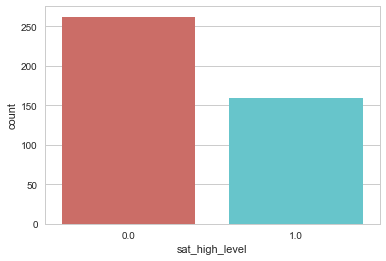

In [92]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='sat_high_level',data=hs_2017, palette='hls')
plt.show()

In [93]:
Y_sat_high=hs_2017['sat_high_level'].values
Y = Y_sat_high
del hs_2017['sat_high_level']
X_highSchools=hs_2017

In [95]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [96]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)


In [97]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=4 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   20.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [99]:
#Diplay the top model parameters
regGridSearch.best_estimator_

LogisticRegression(C=100, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [100]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)


The average accuracy for all cv folds is: 			 0.84471
The average precision for all cv folds is: 			 0.79047
The average recall for all cv folds is: 			 0.79683
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.823529,0.827586,0.705882
1,0.894118,0.885714,0.861111
2,0.764706,0.714286,0.789474
3,0.811765,0.742857,0.787879
4,0.788235,0.666667,0.714286
5,0.870588,0.838710,0.812500
6,0.905882,0.837838,0.939394
7,0.882353,0.828571,0.878788
8,0.835294,0.812500,0.764706
9,0.870588,0.750000,0.714286


In [101]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)


             precision    recall  f1-score   support

        0.0       0.88      0.88      0.88       262
        1.0       0.80      0.80      0.80       159

avg / total       0.85      0.85      0.85       421

[[231  31]
 [ 32 127]]
0.850356294536817


In [102]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

In [103]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools_Scl, Y)


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    7.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [104]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.01, class_weight='none', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [105]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools_Scl, Y, cv)


The average accuracy for all cv folds is: 			 0.79882
The average precision for all cv folds is: 			 0.74924
The average recall for all cv folds is: 			 0.71277
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.847059,0.862069,0.735294
1,0.835294,0.892857,0.694444
2,0.694118,0.642857,0.710526
3,0.788235,0.692308,0.818182
4,0.788235,0.708333,0.607143
5,0.788235,0.750000,0.656250
6,0.788235,0.714286,0.757576
7,0.823529,0.781250,0.757576
8,0.788235,0.766667,0.676471
9,0.847059,0.681818,0.714286


In [106]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools_Scl, Y, 10)

             precision    recall  f1-score   support

        0.0       0.81      0.85      0.83       262
        1.0       0.73      0.66      0.70       159

avg / total       0.78      0.78      0.78       421

[[224  38]
 [ 54 105]]
0.7814726840855107


In [107]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_highSchools, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
   estimator=LogisticRegression(C=0.01, class_weight='none', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 19


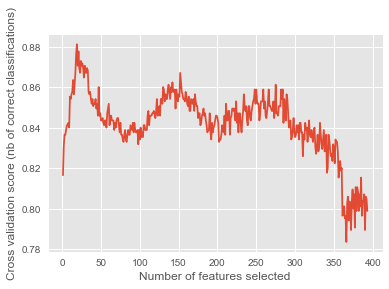

In [70]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [71]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_highSchools.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top50features = rfe_ft_imp_df.head(50)

top50features

,feature_names,weights
18,SPG Score,0.881176
20,NC Math 1 Score,0.877647
17,lea_state_perpupil_num,0.876471
23,ACT Score,0.872941
25,Passing NC Math 3,0.871765
28,ACTScience_ACTBenchmark_All,0.870588
19,EVAAS Growth Score,0.870588
24,ACT WorkKeys Score,0.870588
21,English II Score,0.869412
26,4-Year Cohort Graduation Rate Score,0.869412


In [72]:
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 469
Columns: 393 entries, student_num to unit_code
dtypes: float64(321), int64(72)
memory usage: 1.3 MB


In [51]:
X_highSchools=pd.DataFrame(X_highSchools)

In [84]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#Use recursive feature elimination to get the best features for our model
#(We already did this earlier, but I am including it again below in comment for a complete example!)

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
X_BestFeatures = rfecv.fit_transform(X_highSchools, Y)

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_BestFeatures, Y)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1000, class_weight='none', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [85]:
EvaluateClassifierEstimator(grid.best_estimator_, X_BestFeatures, Y, cv)

The average accuracy for all cv folds is: 			 0.84471
The average precision for all cv folds is: 			 0.81234
The average recall for all cv folds is: 			 0.77332
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.870588,0.870968,0.794118
1,0.823529,0.838710,0.722222
2,0.835294,0.785714,0.868421
3,0.788235,0.714286,0.757576
4,0.835294,0.750000,0.750000
5,0.811765,0.833333,0.625000
6,0.858824,0.838710,0.787879
7,0.870588,0.866667,0.787879
8,0.835294,0.833333,0.735294
9,0.917647,0.791667,0.904762


In [86]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_BestFeatures, Y, 10)

             precision    recall  f1-score   support

        0.0       0.86      0.87      0.87       262
        1.0       0.79      0.77      0.78       159

avg / total       0.84      0.84      0.84       421

[[229  33]
 [ 36 123]]
0.836104513064133


In [87]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
feature_names = X_highSchools.columns.values[rfecv.get_support(indices=True)]

linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

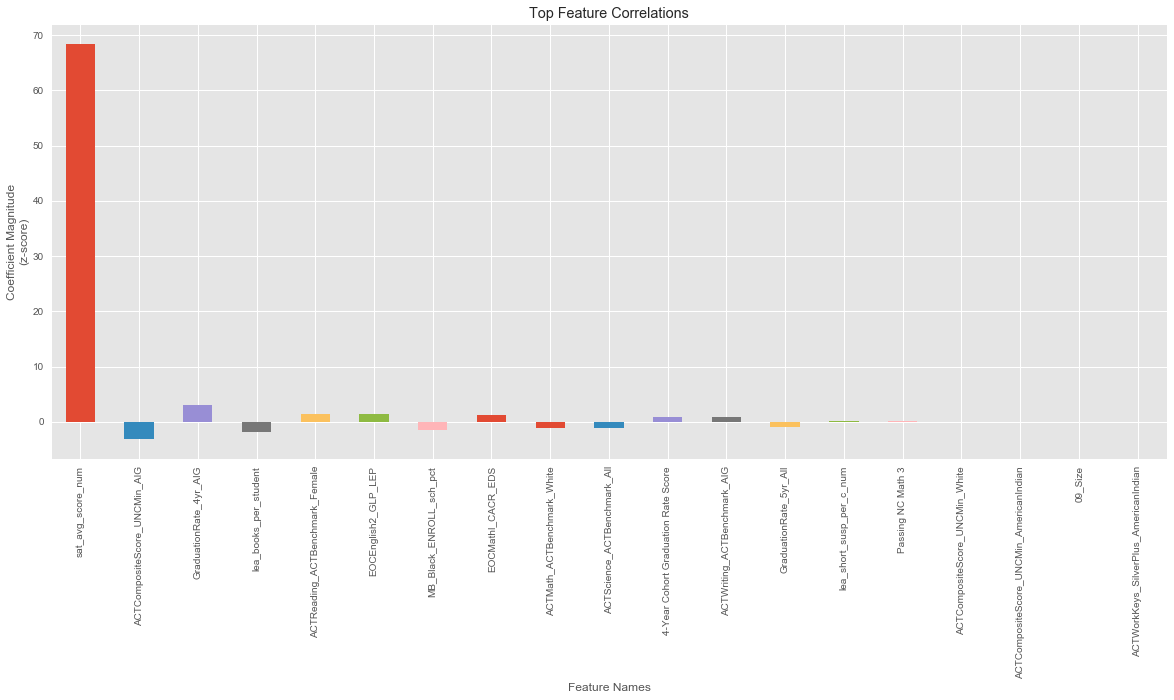

In [88]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()